# Hellow Kaggle.

In [1]:
import tensorflow as tf
# import tensorflow_hub as hub
import numpy as np
import os
import matplotlib.pyplot as plt
from PIL import Image
from skimage import io
from sklearn.metrics import precision_recall_curve, f1_score
import numpy as np
import pandas as pd
from estimator.input_fn import load_labels
import tqdm
import seaborn as sns
# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

%matplotlib inline

/home/binbinx/.local/share/virtualenvs/cs231n-fashion-Wjk4N3Xb/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# use GPU or not 
os.environ["CUDA_VISIBLE_DEVICES"] = '0'

# Choose Best Parameters.

In [3]:
from sklearn.metrics import precision_recall_curve, f1_score
import numpy as np
import pandas as pd
from input_fn import load_labels


def eval_with_threshold(val_pred, val_true, thresholds):
    '''
    evaluate the micro F1 score with the given threshold
    '''
    val_pred = (val_pred >= thresholds).astype(int)
    f1 = f1_score(val_true, val_pred, average='micro')
    return f1

def choose_threshold(val_pred_dense, val_true_dense, mode='micro', 
                     cycle=6):
    '''
    val_pred_dense, val_true_dense: validation_size*num_classes
    mode: 'micro', 'macro', 'unified'
    
    cycle: for micro mode
    '''
    NUM_CLASS = val_pred_dense.shape[1]
    
    # Micro: choose a universal threshold for all classes
    if mode.lower() == 'unified':
        p, r, th = precision_recall_curve(val_true_dense.flatten(), val_pred_dense.flatten())
        f1=2.0*p*r/(p+r+1e-10)
        best_idx=np.argmax(f1)
        return th[best_idx]
    
    elif mode.lower() == 'macro':
        # Macro: for each of the class
        pred_threshold=[]
        for i in range(NUM_CLASS):
            p, r, th = precision_recall_curve(val_true_dense[i], val_pred_dense[i])
            f1=2.0*p*r/(p+r+1e-10)
            best_idx=np.argmax(f1)
            pred_threshold.append(th[best_idx])
        return pred_threshold
    
    elif mode.lower() == 'micro':
        # Micro: for each of the class
        # Use “cyclic optimizatio" from 
        # https://www.csie.ntu.edu.tw/~cjlin/papers/threshold.pdf
        
        # default thresholds.
        # TODO(binbinx): Speed this up by calculating and tracking Confusion Matrix instead of calling
        # eval_with_threshold everytime we change only one class's threshold. This way we can support
        # smaller intervals, such as 0.01 instead of 0.05
        pred_threshold=[0.5 for i in range(NUM_CLASS)] 
        th_candidate=np.linspace(0.05, 0.95, num=19)
        
        max_f1=eval_with_threshold(val_pred, val_true, pred_threshold)
        for cycle in range(cycle):
            cycle_effective=False
            for c in range(NUM_CLASS):
                print('Cycle %d, Class %d'%(cycle+1, c+1))
                # Optimize for each class, while fixing others.
                best_threshold = pred_threshold[c]
                # TODO(binbinx): we could do another round of optimization here,
                # instead of grid search, we could use random search, 
                # if the validation set is too large.
                for t in th_candidate:
                    pred_threshold[c] = t
                    f1 = eval_with_threshold(val_pred, val_true, pred_threshold)
                    if f1 > max_f1:
                        cycle_effective=True
                        print('Found a better f1:%.6f if class %d use %.2f! instead of %.2f'%(f1, c+1, t, best_threshold))
                        max_f1=f1
                        best_threshold=t
                pred_threshold[c] = best_threshold
            if not cycle_effective:
                break
        return pred_threshold
    
    else:
        print('not supported threshold selection.')
            
def read_validation_predictions(val_pred_file, val_label_file):
    label_id = load_labels(val_label_file)
    
    val_pred = pd.read_csv(val_pred_file)['label_prob'].map(lambda x: np.array([float(v) for v in x.split(' ')])).values
    val_pred = np.array(val_pred.tolist())
    val_true = np.zeros_like(val_pred)
    for i in range(len(label_id)):
        key=str(i+1)
        val_true[i][np.array(label_id[key])-1]=1
    
    return val_pred, val_true

def save_thresholds_to_file(thresholds, file_name):
    df = pd.DataFrame({'thresholds': thresholds})
    df.to_csv(file_name)

ModuleNotFoundError: No module named 'input_fn'

In [25]:
np.linspace(0.05, 0.95, num=19)

array([0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55,
       0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95])

In [26]:
# Run threshold choosing function

# val_pred_file='/home/shared/cs231n-fashion/model_dir/baseline_dense/valid_debug_dump.csv'
# val_label_file='/home/fashion/data/validation.json'
val_pred_file='../valid_debug_dump.csv'
val_label_file='../data/validation.json'
val_pred, val_true = read_validation_predictions(val_pred_file, val_label_file)

universal_threshold=choose_threshold(val_pred, val_true, 'unified')
print(universal_threshold, eval_with_threshold(val_pred, val_true, universal_threshold))

micro_threshold=choose_threshold(val_pred, val_true, 'micro')
print(micro_threshold)

# print(eval_with_threshold(val_pred, val_true, per_class_threshold))
# print(eval_with_threshold(val_pred, val_true, universal_threshold))

0.21 0.542264480501146
Cycle 1, Class 1
Cycle 1, Class 2
Found a better f1:0.411923 if class 2 use 0.20!
Cycle 1, Class 3
Found a better f1:0.411930 if class 3 use 0.35!
Cycle 1, Class 4
Found a better f1:0.411985 if class 4 use 0.05!
Found a better f1:0.412131 if class 4 use 0.10!
Cycle 1, Class 5
Found a better f1:0.412314 if class 5 use 0.05!
Cycle 1, Class 6
Found a better f1:0.412389 if class 6 use 0.10!
Found a better f1:0.412452 if class 6 use 0.15!
Cycle 1, Class 7
Found a better f1:0.412473 if class 7 use 0.30!
Found a better f1:0.412480 if class 7 use 0.35!
Cycle 1, Class 8
Cycle 1, Class 9
Cycle 1, Class 10
Found a better f1:0.412579 if class 10 use 0.05!
Found a better f1:0.412616 if class 10 use 0.10!
Cycle 1, Class 11
Found a better f1:0.412707 if class 11 use 0.10!
Found a better f1:0.412746 if class 11 use 0.15!
Cycle 1, Class 12
Cycle 1, Class 13
Cycle 1, Class 14
Found a better f1:0.412991 if class 14 use 0.05!
Cycle 1, Class 15
Found a better f1:0.413973 if class 15 

Cycle 1, Class 83
Cycle 1, Class 84
Cycle 1, Class 85
Cycle 1, Class 86
Cycle 1, Class 87
Cycle 1, Class 88
Found a better f1:0.500486 if class 88 use 0.15!
Found a better f1:0.500708 if class 88 use 0.20!
Found a better f1:0.500712 if class 88 use 0.25!
Cycle 1, Class 89
Found a better f1:0.500723 if class 89 use 0.15!
Found a better f1:0.500757 if class 89 use 0.20!
Cycle 1, Class 90
Cycle 1, Class 91
Found a better f1:0.500842 if class 91 use 0.30!
Found a better f1:0.500926 if class 91 use 0.35!
Cycle 1, Class 92
Found a better f1:0.501026 if class 92 use 0.10!
Found a better f1:0.501075 if class 92 use 0.15!
Found a better f1:0.501121 if class 92 use 0.25!
Cycle 1, Class 93
Found a better f1:0.501124 if class 93 use 0.15!
Found a better f1:0.501147 if class 93 use 0.20!
Found a better f1:0.501177 if class 93 use 0.25!
Cycle 1, Class 94
Cycle 1, Class 95
Found a better f1:0.501231 if class 95 use 0.15!
Found a better f1:0.501322 if class 95 use 0.20!
Found a better f1:0.501390 if c

Found a better f1:0.530456 if class 159 use 0.30!
Cycle 1, Class 160
Found a better f1:0.530475 if class 160 use 0.10!
Found a better f1:0.530486 if class 160 use 0.15!
Cycle 1, Class 161
Cycle 1, Class 162
Cycle 1, Class 163
Cycle 1, Class 164
Found a better f1:0.532626 if class 164 use 0.05!
Found a better f1:0.534768 if class 164 use 0.10!
Found a better f1:0.535015 if class 164 use 0.15!
Cycle 1, Class 165
Found a better f1:0.535035 if class 165 use 0.25!
Found a better f1:0.535055 if class 165 use 0.30!
Found a better f1:0.535089 if class 165 use 0.35!
Cycle 1, Class 166
Found a better f1:0.535099 if class 166 use 0.55!
Cycle 1, Class 167
Found a better f1:0.535105 if class 167 use 0.20!
Found a better f1:0.535116 if class 167 use 0.25!
Found a better f1:0.535134 if class 167 use 0.30!
Cycle 1, Class 168
Cycle 1, Class 169
Found a better f1:0.535152 if class 169 use 0.10!
Found a better f1:0.535323 if class 169 use 0.15!
Found a better f1:0.535339 if class 169 use 0.20!
Found a be

Cycle 2, Class 19
Found a better f1:0.572363 if class 19 use 0.20!
Cycle 2, Class 20
Found a better f1:0.572383 if class 20 use 0.30!
Cycle 2, Class 21
Found a better f1:0.572387 if class 21 use 0.15!
Cycle 2, Class 22
Cycle 2, Class 23
Cycle 2, Class 24
Cycle 2, Class 25
Found a better f1:0.572410 if class 25 use 0.15!
Found a better f1:0.572414 if class 25 use 0.20!
Cycle 2, Class 26
Found a better f1:0.572458 if class 26 use 0.10!
Found a better f1:0.572496 if class 26 use 0.15!
Cycle 2, Class 27
Cycle 2, Class 28
Found a better f1:0.572498 if class 28 use 0.25!
Found a better f1:0.572515 if class 28 use 0.30!
Found a better f1:0.572516 if class 28 use 0.35!
Found a better f1:0.572527 if class 28 use 0.40!
Found a better f1:0.572536 if class 28 use 0.45!
Found a better f1:0.572536 if class 28 use 0.50!
Cycle 2, Class 29
Cycle 2, Class 30
Cycle 2, Class 31
Cycle 2, Class 32
Cycle 2, Class 33
Found a better f1:0.572544 if class 33 use 0.45!
Cycle 2, Class 34
Cycle 2, Class 35
Cycle 2,

Cycle 3, Class 92
Cycle 3, Class 93
Cycle 3, Class 94
Cycle 3, Class 95
Cycle 3, Class 96
Cycle 3, Class 97
Cycle 3, Class 98
Cycle 3, Class 99
Cycle 3, Class 100
Cycle 3, Class 101
Cycle 3, Class 102
Cycle 3, Class 103
Cycle 3, Class 104
Cycle 3, Class 105
Cycle 3, Class 106
Cycle 3, Class 107
Cycle 3, Class 108
Cycle 3, Class 109
Cycle 3, Class 110
Cycle 3, Class 111
Cycle 3, Class 112
Cycle 3, Class 113
Cycle 3, Class 114
Cycle 3, Class 115
Cycle 3, Class 116
Cycle 3, Class 117
Cycle 3, Class 118
Cycle 3, Class 119
Cycle 3, Class 120
Cycle 3, Class 121
Cycle 3, Class 122
Cycle 3, Class 123
Cycle 3, Class 124
Cycle 3, Class 125
Cycle 3, Class 126
Cycle 3, Class 127
Cycle 3, Class 128
Cycle 3, Class 129
Cycle 3, Class 130
Cycle 3, Class 131
Cycle 3, Class 132
Cycle 3, Class 133
Cycle 3, Class 134
Cycle 3, Class 135
Cycle 3, Class 136
Cycle 3, Class 137
Cycle 3, Class 138
Cycle 3, Class 139
Cycle 3, Class 140
Cycle 3, Class 141
Cycle 3, Class 142
Cycle 3, Class 143
Cycle 3, Class 144
C

In [27]:
thresholds_filename='/home/shared/cs231n-fashion/model_dir/baseline_dense/thresholds.csv'
thresholds_filename='../thresholds2.csv'
save_thresholds_to_file(micro_threshold, thresholds_filename)

In [28]:
df=pd.read_csv(thresholds_filename)
df['thresholds'].values

array([0.5 , 0.45, 0.6 , 0.15, 0.05, 0.2 , 0.7 , 0.5 , 0.5 , 0.1 , 0.25,
       0.5 , 0.5 , 0.1 , 0.2 , 0.5 , 0.15, 0.25, 0.2 , 0.3 , 0.15, 0.15,
       0.5 , 0.5 , 0.2 , 0.15, 0.25, 0.5 , 0.6 , 0.15, 0.25, 0.15, 0.45,
       0.3 , 0.5 , 0.25, 0.2 , 0.25, 0.15, 0.1 , 0.5 , 0.5 , 0.3 , 0.2 ,
       0.5 , 0.5 , 0.1 , 0.5 , 0.2 , 0.5 , 0.35, 0.3 , 0.15, 0.55, 0.2 ,
       0.25, 0.5 , 0.2 , 0.1 , 0.6 , 0.75, 0.25, 0.4 , 0.9 , 0.3 , 0.3 ,
       0.2 , 0.25, 0.5 , 0.15, 0.3 , 0.2 , 0.4 , 0.35, 0.2 , 0.5 , 0.5 ,
       0.1 , 0.2 , 0.5 , 0.4 , 0.75, 0.5 , 0.5 , 0.5 , 0.5 , 0.5 , 0.25,
       0.2 , 0.5 , 0.35, 0.25, 0.25, 0.5 , 0.35, 0.3 , 0.2 , 0.3 , 0.15,
       0.15, 0.2 , 0.25, 0.25, 0.5 , 0.35, 0.3 , 0.5 , 0.5 , 0.95, 0.55,
       0.05, 0.5 , 0.55, 0.2 , 0.25, 0.4 , 0.5 , 0.5 , 0.05, 0.7 , 0.35,
       0.7 , 0.1 , 0.15, 0.5 , 0.15, 0.2 , 0.6 , 0.5 , 0.5 , 0.2 , 0.1 ,
       0.25, 0.5 , 0.2 , 0.15, 0.15, 0.55, 0.25, 0.5 , 0.1 , 0.2 , 0.25,
       0.7 , 0.5 , 0.65, 0.4 , 0.25, 0.5 , 0.15, 0.

# Play with input_fn

In [11]:
import numpy as np

np.linspace(0.05, 0.95, num=19)

array([0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55,
       0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95])

In [3]:
# Define global variables.
hidden_size = 100
num_classes = 228
learning_rate = 3e-4
num_train_steps = 10
num_train_per_eval = 2

# input_fn arguments.
should_augment = False
images_limit = 1000  # How many images to train.
batch_size = 32
num_threads = 8
input_folder = '/home/shared/cs231n-fashion/data/train_processed'
label_json_path = '/home/shared/cs231n-fashion/data/train.json'

In [4]:
# Set up some global variables
gpu_to_use = 0
os.environ["CUDA_VISIBLE_DEVICES"] = str(gpu_to_use)

In [8]:
from PIL import Image
import numpy as np
import tensorflow as tf


def _bytes_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _int64_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def _int64_list_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=value))

def _label_feature(labels):
    return _bytes_feature(''.join([str(i) for i in labels]))

tfrecords_filename = '/home/shared/cs231n-fashion/data/train_empty.tfrecords'

filename_pairs = [
('/home/shared/cs231n-fashion/data/train_processed/36.jpg', [1 for i in range(228)])
]
 
writer = tf.python_io.TFRecordWriter(tfrecords_filename)

# Let's collect the real images to later on compare
# to the reconstructed ones
original_images = []

for img_path, labels in filename_pairs:
    
    img = np.array(Image.open(img_path))
    
    # The reason to store image sizes was demonstrated
    # in the previous example -- we have to know sizes
    # of images to later read raw serialized string,
    # convert to 1d array and convert to respective
    # shape that image used to have.
    height = img.shape[0]
    width = img.shape[1]
    
    # Put in the original images into array
    # Just for future check for correctness
    original_images.append((img, labels))
    
    img_raw = img.tostring()
    
    example = tf.train.Example(features=tf.train.Features(feature={
        'height': _int64_feature(height),
        'width': _int64_feature(width),
        'image_raw': _bytes_feature(img_raw),
        'label_raw': _int64_list_feature(labels)}))
    
    writer.write(example.SerializeToString())

writer.close()



In [9]:
reconstructed_images = []

record_iterator = tf.python_io.tf_record_iterator(path=tfrecords_filename)

for string_record in record_iterator:
    
    example = tf.train.Example()
    example.ParseFromString(string_record)
    
    height = int(example.features.feature['height']
                                 .int64_list
                                 .value[0])
    
    width = int(example.features.feature['width']
                                .int64_list
                                .value[0])
    
    img_string = (example.features.feature['image_raw']
                                  .bytes_list
                                  .value[0])
    
    labels = (example.features.feature['label_raw']
                                .int64_list.value)

    img_1d = np.frombuffer(img_string, dtype=np.uint8)
    reconstructed_img = img_1d.reshape((height, width, -1))
    
    reconstructed_images.append((reconstructed_img, labels))

True
True


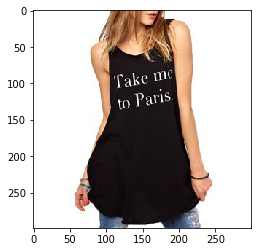

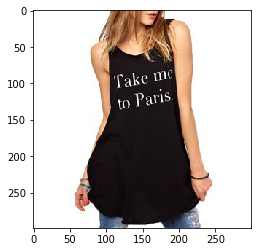

In [12]:
for original_pair, reconstructed_pair in zip(original_images, reconstructed_images):
    
    img_pair_to_compare, annotation_pair_to_compare = zip(original_pair,
                                                          reconstructed_pair)
    print(np.allclose(*img_pair_to_compare))
    print(np.allclose(*annotation_pair_to_compare))
    plt.imshow(original_pair[0])
    plt.show()
    plt.imshow(reconstructed_pair[0])

In [ ]:
data_path = '/home/shared/cs231n-fashion/data/validation_processed.tfrecords/'  # address to save the hdf5 file
with tf.Session() as sess:
    feature = {
        'height': tf.FixedLenFeature([], tf.int64),
        'width': tf.FixedLenFeature([], tf.int64),
        'image_float': tf.FixedLenFeature([], tf.float32),
        'labels': tf.FixedLenFeature([], tf.int64)}
    # Create a list of filenames and pass it to a queue
    filename_queue = tf.train.string_input_producer([data_path], num_epochs=1)
    # Define a reader and read the next record
    reader = tf.TFRecordReader()
    _, serialized_example = reader.read(filename_queue)
    # Decode the record read by the reader
    features = tf.parse_single_example(serialized_example, features=feature)
    
    # Cast label data into int32
    label = tf.cast(features['labels'], tf.int32)
    # Reshape image data into the original shape
    image = tf.reshape(image, [224, 224, 3])
    image *= 255
    
    


/home/binbinx/.local/share/virtualenvs/cs231n-fashion-Wjk4N3Xb/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  app.launch_new_instance()


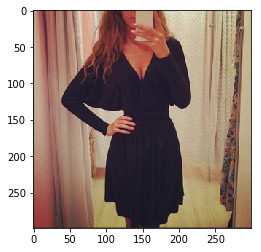

[62, 17, 66, 214, 105, 137, 85]


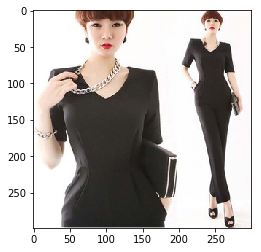

[95, 17, 66, 214, 164, 137, 20, 204, 184]


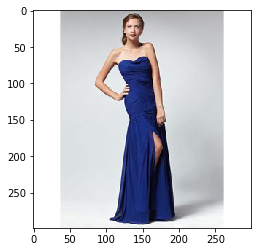

[122, 19, 66, 186, 180, 44, 154, 20]


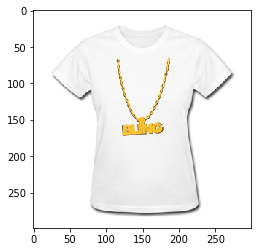

[190, 222, 66, 153, 164, 226, 53, 184]


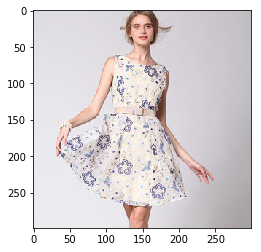

[62, 66, 153, 171, 111, 137, 70, 204, 184]


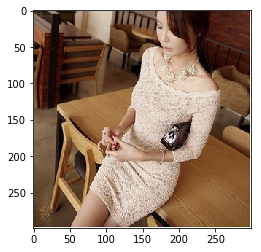

[62, 66, 153, 105, 14, 17, 98, 20]


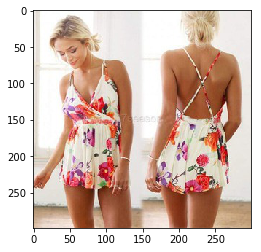

[12, 66, 214, 171, 111, 137, 70, 175, 54, 138]


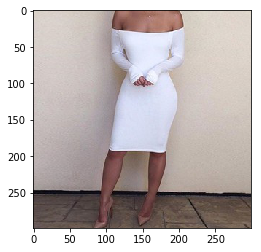

[62, 66, 116, 222, 105, 14, 176, 137, 53, 20]


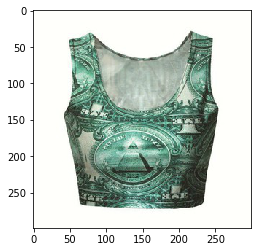

[56, 66, 171, 111, 210, 137, 184]


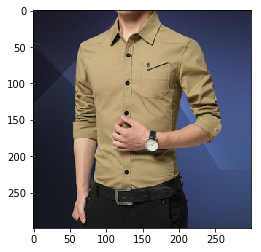

[61, 106, 49, 105, 14, 53]


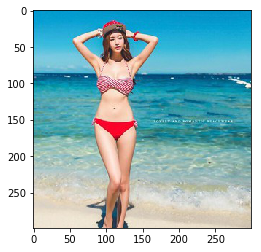

[15, 66, 148, 222, 186, 171, 176, 115, 181, 175]


In [38]:
data_path = '/home/shared/cs231n-fashion/data/validation_processed.tfrecords'  # address to save the hdf5 file

record_iterator = tf.python_io.tf_record_iterator(path=data_path)

counter=0
for string_record in record_iterator:
    example = tf.train.Example()
    example.ParseFromString(string_record)
    img_byte = (example.features.feature['image'].bytes_list
                                  .value[0])
    
    labels_string = (example.features.feature['labels']
                                .int64_list
                                .value)
    
    img_1d = np.fromstring(img_byte, dtype=np.uint8)
    reconstructed_img = img_1d.reshape((299, 299, -1))
    plt.imshow(reconstructed_img)
    plt.show()
    print (labels_string)
    counter+=1
    
    if counter>10:
        break

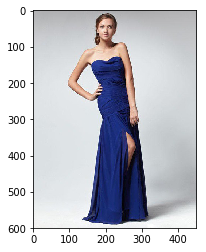

In [17]:
plt.imshow(Image.open("/home/fashion/data/validation_images/3.jpg"))

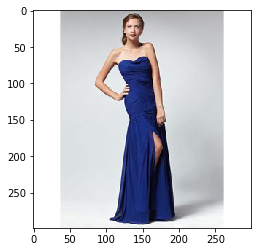

In [18]:
plt.imshow(Image.open("/home/fashion/data/validation_processed/3.jpg"))

In [112]:
tf.reset_default_graph()

In [113]:
%matplotlib inline

import tensorflow as tf
import skimage.io as io

IMAGE_SIZE = 299

tfrecords_filename = '/home/shared/cs231n-fashion/data/validation_processed.tfrecords'

def read_and_decode(filename_queue):
    reader = tf.TFRecordReader()
    _, serialized_example = reader.read(filename_queue)
    
    features = tf.parse_single_example(
      serialized_example,
      features={
        'image': tf.FixedLenFeature([], tf.string),
        'labels': tf.VarLenFeature(tf.int64),
        })
    
    # Convert from a scalar string tensor (whose single string has
    # length mnist.IMAGE_PIXELS) to a uint8 tensor with shape
    # [mnist.IMAGE_PIXELS].
    image = tf.decode_raw(features['image'], tf.uint8)
    image = tf.reshape(image, (IMAGE_SIZE, IMAGE_SIZE, 3))
    image = tf.cast(image, tf.float32)
    image = image / 255.0
    label_sparse = tf.sparse_tensor_to_dense(features['labels'])
    label_dense = tf.reshape(label_sparse, (-1, 1))
    label = tf.scatter_nd(label_dense-1, tf.ones(tf.shape(label_dense)[0]), [228])
#     images, labels = tf.train.shuffle_batch([image, label],
#                                              batch_size=2,
#                                              capacity=2,
#                                              num_threads=2,
#                                              min_after_dequeue=1)
#     images, labels = tf.train.batch([image, label],
#                                     batch_size=1,
#                                     capacity=1,
#                                     num_threads=1,)
    return image, label, label_dense
#     return images, labels, label_dense

In [114]:
filename_queue = tf.train.string_input_producer(
    [tfrecords_filename], num_epochs=10)

# Even when reading in multiple threads, share the filename
# queue.
image, annotation, label_sparse = read_and_decode(filename_queue)

# The op for initializing the variables.
init_op = tf.group(tf.global_variables_initializer(),
                   tf.local_variables_initializer())
with tf.Session()  as sess:
    sess.run(init_op)
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(coord=coord)
    
    # Let's read off 3 batches just for example
    for i in range(1):
    
        img, anno, label = sess.run([image, annotation, label_sparse])
        print(img.shape)
        print(anno, label)
        
        print('current batch')
        
        # We selected the batch size of two
        # So we should get two image pairs in each batch
        # Let's make sure it is random

#         io.imshow(img[0, :, :, :])
#         io.show()

#         io.imshow(img[1, :, :, :])
#         io.show()

    coord.request_stop()
    coord.join(threads)

(299, 299, 3)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [[ 62]
 [ 17]
 [ 66]
 [214]
 [105]
 [137]
 [ 85]]
current batch


In [117]:
data=[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,]


In [121]:
dan=np.array(data)
for i in range(len(dan)):
    if dan[i]==1:
        print(i+1)

17
62
66
85
105
137
214


[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
 0. 0. 0. 0. 

/home/binbinx/.local/share/virtualenvs/cs231n-fashion-Wjk4N3Xb/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and
/home/binbinx/.local/share/virtualenvs/cs231n-fashion-Wjk4N3Xb/lib/python3.6/site-packages/matplotlib/axes/_base.py:1400: MatplotlibDeprecationWarning: The 'box-forced' keyword argument is deprecated since 2.2.
  " since 2.2.", cbook.mplDeprecation)


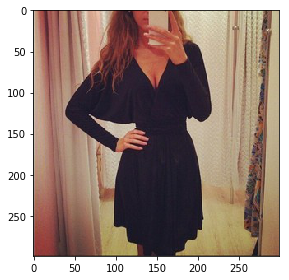

(32, 299, 299, 3) (32, 228)


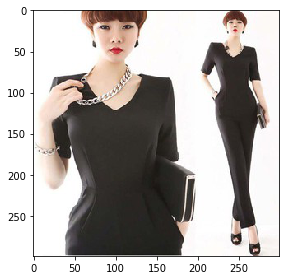

In [126]:
from input_fn import tf_record_input_fn

# The op for initializing the variables.
init_op = tf.group(tf.global_variables_initializer(),
                   tf.local_variables_initializer())
tfrecords_filename='/home/shared/cs231n-fashion/data/validation_processed.tfrecords'

data, label=tf_record_input_fn(tfrecords_filename, repeat=False, shuffle=False)

with tf.Session()  as sess:
    sess.run(init_op)
    img, labels = sess.run([data, label])
    print(labels[0])
    print(labels[1])
    io.imshow(img[0, :, :, :])
    io.show()
    io.imshow(img[1, :, :, :])
    print(img.shape, labels.shape)

In [127]:
b=[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,]

for i in range(len(b)):
    if b[i]==1:
        print(i+1)

17
62
66
85
105
137
214


# Training with Keras

In [6]:
from keras.applications.densenet import DenseNet169

from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K

# tf.reset_default_graph()
def train_with_keras():
    
    # 1. Initialize
    # 2. Fine Tune
    # 3. ...
    
    # create the base pre-trained model
    base_model = DenseNet169(weights='imagenet', 
                                 input_shape=(299,299, 3), 
                                 include_top=False)

#     # add a global spatial average pooling layer
#     x = base_model.output
#     x = GlobalAveragePooling2D()(x)
#     # let's add a fully-connected layer
#     x = Dense(2048, activation='relu')(x)
#     # and a logistic layer -- let's say we have 200 classes
#     probs = Dense(228, activation='sigmoid')(x)

#     # this is the model we will train
#     model = Model(inputs=base_model.input, outputs=probs)
    for i, layer in enumerate(base_model.layers):
        layer.trainable = False
        print(i, layer.name, layer.output)
#     # first: train only the top layers (which were randomly initialized)
#     # i.e. freeze all convolutional Xception layers
#     for layer in base_model.layers:
#         layer.trainable = False

#     # compile the model (should be done *after* setting layers to non-trainable)
#     model.compile(optimizer='rmsprop', loss='categorical_crossentropy')

#     # train the model on the new data for a few epochs
#     model.fit_generator(...)
    
#     # at this point, the top layers are well trained and we can start fine-tuning
#     # convolutional layers from inception V3. We will freeze the bottom N layers
#     # and train the remaining top layers.

#     # let's visualize layer names and layer indices to see how many layers
#     # we should freeze:
#     for i, layer in enumerate(base_model.layers):
#        print(i, layer.output)

#     # we chose to train the top 2 inception blocks, i.e. we will freeze
#     # the first 249 layers and unfreeze the rest:
#     for layer in model.layers[:249]:
#        layer.trainable = False
#     for layer in model.layers[249:]:
#        layer.trainable = True

#     # we need to recompile the model for these modifications to take effect
#     # we use SGD with a low learning rate
#     from keras.optimizers import SGD
#     model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy')

train_with_keras()

0 input_1 Tensor("input_1:0", shape=(?, 299, 299, 3), dtype=float32)
1 zero_padding2d_1 Tensor("zero_padding2d_1/Pad:0", shape=(?, 305, 305, 3), dtype=float32)
2 conv1/conv Tensor("conv1/conv/convolution:0", shape=(?, 150, 150, 64), dtype=float32)
3 conv1/bn Tensor("conv1/bn/cond/Merge:0", shape=(?, 150, 150, 64), dtype=float32)
4 conv1/relu Tensor("conv1/relu/Relu:0", shape=(?, 150, 150, 64), dtype=float32)
5 zero_padding2d_2 Tensor("zero_padding2d_2/Pad:0", shape=(?, 152, 152, 64), dtype=float32)
6 pool1 Tensor("pool1/MaxPool:0", shape=(?, 75, 75, 64), dtype=float32)
7 conv2_block1_0_bn Tensor("conv2_block1_0_bn/cond/Merge:0", shape=(?, 75, 75, 64), dtype=float32)
8 conv2_block1_0_relu Tensor("conv2_block1_0_relu/Relu:0", shape=(?, 75, 75, 64), dtype=float32)
9 conv2_block1_1_conv Tensor("conv2_block1_1_conv/convolution:0", shape=(?, 75, 75, 128), dtype=float32)
10 conv2_block1_1_bn Tensor("conv2_block1_1_bn/cond/Merge:0", shape=(?, 75, 75, 128), dtype=float32)
11 conv2_block1_1_relu

In [3]:
train_with_keras()

0 Tensor("input_3:0", shape=(?, ?, ?, 3), dtype=float32)
1 Tensor("block1_conv1_2/convolution:0", shape=(?, ?, ?, 32), dtype=float32)
2 Tensor("block1_conv1_bn_2/cond/Merge:0", shape=(?, ?, ?, 32), dtype=float32)
3 Tensor("block1_conv1_act_2/Relu:0", shape=(?, ?, ?, 32), dtype=float32)
4 Tensor("block1_conv2_2/convolution:0", shape=(?, ?, ?, 64), dtype=float32)
5 Tensor("block1_conv2_bn_2/cond/Merge:0", shape=(?, ?, ?, 64), dtype=float32)
6 Tensor("block1_conv2_act_2/Relu:0", shape=(?, ?, ?, 64), dtype=float32)
7 Tensor("block2_sepconv1_2/separable_conv2d:0", shape=(?, ?, ?, 128), dtype=float32)
8 Tensor("block2_sepconv1_bn_2/cond/Merge:0", shape=(?, ?, ?, 128), dtype=float32)
9 Tensor("block2_sepconv2_act_2/Relu:0", shape=(?, ?, ?, 128), dtype=float32)
10 Tensor("block2_sepconv2_2/separable_conv2d:0", shape=(?, ?, ?, 128), dtype=float32)
11 Tensor("block2_sepconv2_bn_2/cond/Merge:0", shape=(?, ?, ?, 128), dtype=float32)
12 Tensor("conv2d_9/convolution:0", shape=(?, ?, ?, 128), dtype=f

In [8]:
train_with_keras()

0 input_7 Tensor("input_7:0", shape=(?, ?, ?, 3), dtype=float32)
1 block1_conv1 Tensor("block1_conv1_6/convolution:0", shape=(?, ?, ?, 32), dtype=float32)
2 block1_conv1_bn Tensor("block1_conv1_bn_6/cond/Merge:0", shape=(?, ?, ?, 32), dtype=float32)
3 block1_conv1_act Tensor("block1_conv1_act_6/Relu:0", shape=(?, ?, ?, 32), dtype=float32)
4 block1_conv2 Tensor("block1_conv2_6/convolution:0", shape=(?, ?, ?, 64), dtype=float32)
5 block1_conv2_bn Tensor("block1_conv2_bn_6/cond/Merge:0", shape=(?, ?, ?, 64), dtype=float32)
6 block1_conv2_act Tensor("block1_conv2_act_6/Relu:0", shape=(?, ?, ?, 64), dtype=float32)
7 block2_sepconv1 Tensor("block2_sepconv1_6/separable_conv2d:0", shape=(?, ?, ?, 128), dtype=float32)
8 block2_sepconv1_bn Tensor("block2_sepconv1_bn_6/cond/Merge:0", shape=(?, ?, ?, 128), dtype=float32)
9 block2_sepconv2_act Tensor("block2_sepconv2_act_6/Relu:0", shape=(?, ?, ?, 128), dtype=float32)
10 block2_sepconv2 Tensor("block2_sepconv2_6/separable_conv2d:0", shape=(?, ?, ?,

##  Initialize

In [24]:
tf.keras.applications.xception

<module 'tensorflow.tools.api.generator.api.keras.applications.xception' from '/usr/local/google/home/binbinx/.local/share/virtualenvs/cs231n-fashion-gVaebfG3/lib/python3.5/site-packages/tensorflow/tools/api/generator/api/keras/applications/xception/__init__.py'>

In [3]:
from keras.applications.xception import Xception
from keras.preprocessing import image
from keras import metrics
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D

# create the base pre-trained model
base_model = Xception(weights='imagenet', include_top=False)

# add a global spatial max pooling layer
x = base_model.output #(?,3,3,2048)
x = GlobalAveragePooling2D()(x) #(?, 2048)

# let's add a fully-connected layer
x = Dense(2048, activation='relu')(x)
# 228 classes 
predictions = Dense(228, activation='sigmoid')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer='rmsprop', 
              loss='binary_crossentropy',
              metrics=['accuracy'])

print (model.summary())

Using TensorFlow backend.


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, None, None, 3 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, None, None, 3 0           block1_conv1_bn[0][0]            
__________________________________________________________________________________________________
block1_con

In [4]:
# hyper parameters for model
nb_classes = 2  # number of classes
based_model_last_block_layer_number = 126  # value is based on based model selected.
img_width, img_height = 299, 299  # change based on the shape/structure of your images
batch_size = 32  # try 4, 8, 16, 32, 64, 128, 256 dependent on CPU/GPU memory capacity (powers of 2 values).
nb_epoch = 50  # number of iteration the algorithm gets trained.
learn_rate = 1e-4  # sgd learning rate
momentum = .9  # sgd momentum to avoid local minimum
transformation_ratio = .05  # how aggressive will be the data augmentation/transformation

# train_data_dir = '../data/validation_images/'
# validation_data_dir = '../data/validation_images/'
# model_path = '../model_dir/keras_baseline/'
train_data_dir = '/home/fashion/data/train_processed/'
validation_data_dir = '/home/fashion/data/validation_processed/'
test_data_dir = '/home/fashion/data/test_processed/'
model_path = '../model_dir/keras_xception/'
train_json = '/home/fashion/data/train.json'
validation_json = '/home/fashion/data/validation.json'


## Training new layer

In [6]:
from utils.keras_image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from input_fn import load_labels

train_label_map = load_labels(json_path=train_json)
valid_label_map = load_labels(json_path=validation_json)

# Read Data and Augment it: Make sure to select augmentations that are appropriate to your images.
# To save augmentations un-comment save lines and add to your flow parameters.
# train_datagen = ImageDataGenerator(rescale=1. / 255)
# #                                    rotation_range=transformation_ratio,
# #                                    shear_range=transformation_ratio,
# #                                    zoom_range=transformation_ratio,
# #                                    cval=transformation_ratio,
# #                                    horizontal_flip=True,
# #                                    vertical_flip=True)
validation_datagen = ImageDataGenerator(rescale=1. / 255)

# # os.makedirs(os.path.join(os.path.abspath(train_data_dir), '../preview'), exist_ok=True)
# train_generator = train_datagen.flow_from_directory(train_data_dir,
#                                                     classes=range(228),
#                                                     target_size=(img_width, img_height),
#                                                     batch_size=batch_size,
#                                                     class_mode='multilabel',
#                                                     multilabel_classes=train_label_map)
# save_to_dir=os.path.join(os.path.abspath(train_data_dir), '../preview')
# save_prefix='aug',
# save_format='jpeg')
# use the above 3 commented lines if you want to save and look at how the data augmentations look like
validation_generator = validation_datagen.flow_from_directory(validation_data_dir,
                                                              classes=range(228),
                                                              target_size=(img_width, img_height),
                                                              batch_size=batch_size,
                                                              shuffle=False,
                                                              class_mode='multilabel',
                                                              multilabel_classes=train_label_map)# or sparse, check input.

Found 9897 images belonging to 228 classes.


In [5]:
from utils.keras_image import ImageDataGenerator
validation_datagen = ImageDataGenerator(rescale=1. / 255)
validation_generator = validation_datagen.flow_from_directory(validation_data_dir,
                                                              classes=range(228),
                                                              target_size=(img_width, img_height),
                                                              batch_size=batch_size,
                                                              shuffle=False,
                                                              class_mode='multilabel',
                                                              multilabel_classes=train_label_map)# or sparse, check input.

NameError: name 'train_label_map' is not defined

In [14]:
test_datagen = ImageDataGenerator(rescale=1. / 255)
test_generator = test_datagen.flow_from_directory(test_data_dir,
                                                      classes=range(228),
                                                      target_size=(299, 299),
                                                      batch_size=32,
                                                      shuffle=False,
                                                      class_mode=None)

Found 39706 images belonging to 228 classes.


In [11]:
top_weights_path = os.path.join(os.path.abspath(model_path), 'top_model_weights.h5')
model.load_weights(top_weights_path)

In [24]:
%%time
pred=model.predict_generator(test_generator, max_queue_size=512, workers=1,
                             use_multiprocessing=False, verbose=1)

  34/1241 [..............................] - ETA: 4:43

KeyboardInterrupt: 

In [23]:
len(pred)

41594

In [14]:
validation_generator.filenames

['1.jpg',
 '2.jpg',
 '3.jpg',
 '4.jpg',
 '5.jpg',
 '6.jpg',
 '7.jpg',
 '8.jpg',
 '9.jpg',
 '10.jpg',
 '11.jpg',
 '12.jpg',
 '13.jpg',
 '14.jpg',
 '15.jpg',
 '16.jpg',
 '17.jpg',
 '18.jpg',
 '19.jpg',
 '20.jpg',
 '21.jpg',
 '22.jpg',
 '23.jpg',
 '24.jpg',
 '25.jpg',
 '26.jpg',
 '27.jpg',
 '28.jpg',
 '29.jpg',
 '30.jpg',
 '31.jpg',
 '32.jpg',
 '33.jpg',
 '34.jpg',
 '35.jpg',
 '36.jpg',
 '37.jpg',
 '38.jpg',
 '39.jpg',
 '40.jpg',
 '41.jpg',
 '42.jpg',
 '43.jpg',
 '44.jpg',
 '45.jpg',
 '46.jpg',
 '47.jpg',
 '48.jpg',
 '49.jpg',
 '50.jpg',
 '51.jpg',
 '52.jpg',
 '53.jpg',
 '54.jpg',
 '55.jpg',
 '56.jpg',
 '57.jpg',
 '58.jpg',
 '59.jpg',
 '60.jpg',
 '61.jpg',
 '62.jpg',
 '63.jpg',
 '64.jpg',
 '65.jpg',
 '66.jpg',
 '67.jpg',
 '68.jpg',
 '69.jpg',
 '70.jpg',
 '71.jpg',
 '72.jpg',
 '73.jpg',
 '74.jpg',
 '75.jpg',
 '76.jpg',
 '77.jpg',
 '78.jpg',
 '79.jpg',
 '80.jpg',
 '81.jpg',
 '82.jpg',
 '83.jpg',
 '84.jpg',
 '85.jpg',
 '86.jpg',
 '87.jpg',
 '88.jpg',
 '89.jpg',
 '90.jpg',
 '91.jpg',
 '92.jpg

In [52]:
# save weights of best training epoch: monitor either val_loss or val_acc


callbacks_list = [
    ModelCheckpoint(top_weights_path, monitor='val_acc', verbose=1, save_best_only=True),
    EarlyStopping(monitor='val_acc', patience=5, verbose=0),
    TensorBoard(log_dir=os.path.join(os.path.abspath(model_path), 'log/'), 
                histogram_freq=0, batch_size=32, write_graph=True, write_grads=False, write_images=True, 
                embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None)

]

# Train Simple CNN
model.fit_generator(train_generator,
                    use_multiprocessing=True,
                    max_queue_size=512,
                    epochs=200,
                    workers=12,
                    steps_per_epoch=5000,
                    validation_data=validation_generator,
                    callbacks=callbacks_list)

Epoch 1/200
5000/5000 [==============================] - 977s 195ms/step - loss: 0.0699 - acc: 0.9792 - val_loss: 0.1126 - val_acc: 0.9740

Epoch 00001: val_acc improved from -inf to 0.97405, saving model to /home/shared/cs231n-fashion/model_dir/keras_xception/top_model_weights.h5
Epoch 2/200
5000/5000 [==============================] - 974s 195ms/step - loss: 0.0696 - acc: 0.9792 - val_loss: 0.1078 - val_acc: 0.9743

Epoch 00002: val_acc improved from 0.97405 to 0.97429, saving model to /home/shared/cs231n-fashion/model_dir/keras_xception/top_model_weights.h5
Epoch 3/200
 834/5000 [====>.........................] - ETA: 12:23 - loss: 0.0696 - acc: 0.9792

Process ForkPoolWorker-26:
Process ForkPoolWorker-25:
Process ForkPoolWorker-27:


KeyboardInterrupt: 

Process ForkPoolWorker-32:
Process ForkPoolWorker-23:
Process ForkPoolWorker-31:
Process ForkPoolWorker-28:
Process ForkPoolWorker-24:
Process ForkPoolWorker-30:
Process ForkPoolWorker-29:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/shared/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/home/shared/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/shared/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/shared/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/

  File "/home/shared/anaconda3/lib/python3.6/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/home/shared/anaconda3/lib/python3.6/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File "/home/shared/anaconda3/lib/python3.6/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
KeyboardInterrupt


In [30]:
        print(i)

17
66
114
148
158
164
214
222


In [ ]:
# train the model on the new data for a few epochs
model.fit_generator(generator, 
                    steps_per_epoch=None, 
                    epochs=1, 
                    verbose=1, 
                    callbacks=None, 
                    validation_data=None, 
                    validation_steps=None, 
                    class_weight=None, 
                    max_queue_size=10, 
                    workers=1,
                    use_multiprocessing=False,
                    shuffle=True,
                    initial_epoch=0)

## Save model & Eval

## Fine tune more layers

# Pretrain Label Embedding

In [4]:
# get label matrix from training example and validation example
# since this is unsupervised learning, we use all exmaples that are available.
train_label_file='/home/fashion/data/train.json'
val_label_file='/home/fashion/data/validation.json'

train_label_id = load_labels(train_label_file)
val_label_id = load_labels(val_label_file)

In [25]:
comatrix_train = np.zeros((228,228))

In [26]:
comatrix_valid = np.zeros((228,228))

In [27]:
for val in train_label_id.values():
    size = len(val)
    for i in range(size-1):
        for j in range(i+1, size):
            comatrix_train[val[i]-1][val[j]-1] += 1
            comatrix_train[val[j]-1][val[i]-1] += 1

In [28]:
for val in val_label_id.values():
    size = len(val)
    for i in range(size-1):
        for j in range(i+1, size):
            comatrix_valid[val[i]-1][val[j]-1] += 1
            comatrix_valid[val[j]-1][val[i]-1] += 1

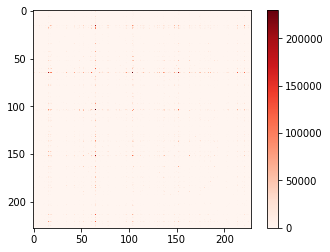

In [29]:
plt.imshow(comatrix_train,interpolation='nearest', cmap='Reds')
plt.colorbar()
plt.show()

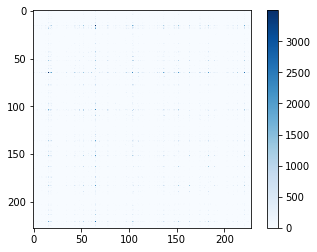

In [31]:
plt.imshow(comatrix_valid,interpolation='nearest', cmap='Blues')
plt.colorbar()
plt.show()

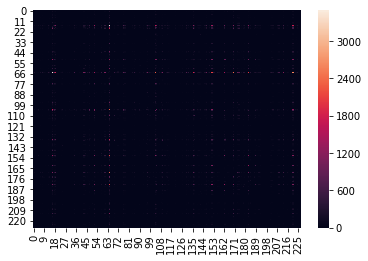

In [32]:
sns.heatmap(comatrix_valid)

In [20]:
train = np.log(comatrix_train+0.1)

In [36]:
np.max(comatrix_train)

229423.0

In [37]:
train_ratio=comatrix_train/(np.max(comatrix_train)+0.1)

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

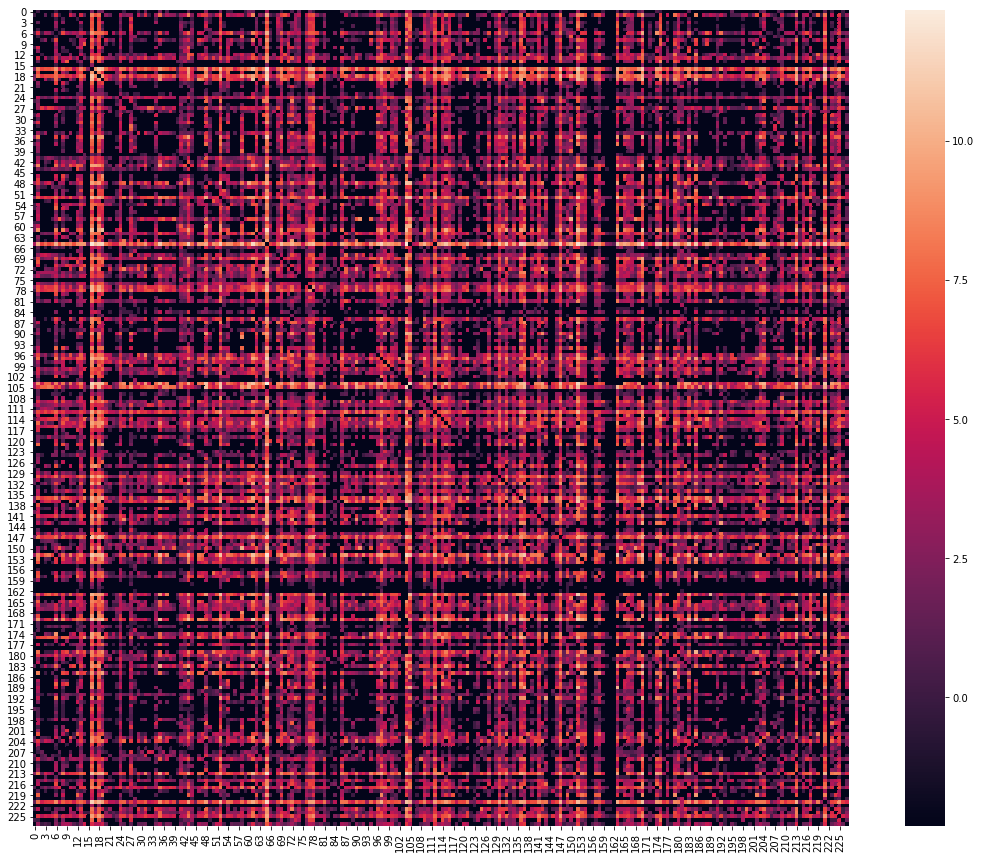

In [53]:
plt.figure(figsize=(20,15))
sns.heatmap(train, square=True)